In [2]:
import glob

import librosa
from librosa import display
from IPython.display import Audio

from fastai_audio.audio import (
    Path,
    SpectrogramConfig,
    AudioItem,
    AudioConfig,
    AudioList,
    audio_learner,
    audio_predict,
    ClassificationInterpretation,
    get_spectro_transforms,
)

from fastai.vision import load_learner

import numpy as np
import torch

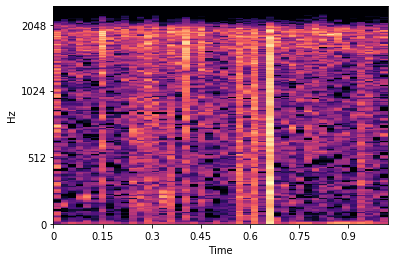

In [74]:
import glob

file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

y, sr = librosa.load(
    "recordings/20150623-044023.wav",
    offset=290,
    duration=2,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=1024, power=2.0, n_mels=192, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

#sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

In [76]:
import soundfile as sf
sf.write(f"question.wav", y, sr)

In [8]:
path = Path("output/")

#sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=1024, hop_length=256, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
#db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-04, top_db=40.0)
#librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

sg_cfg = SpectrogramConfig(n_fft=2560, hop_length=256, n_mels=192, top_db=60, f_max=2500)

config = AudioConfig(
    use_spectro=True,
    sg_cfg=sg_cfg,
    duration=1000
)

#label_pattern = r'_([mf]\d+)_'
al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
#al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_const("damselfish")

In [9]:
tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
#tfms = None
db = al.transform(tfms).databunch(bs=64)
db.show_batch(rows=10)

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 0.67 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 0.78 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 0.8 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/199.wav
Total Length: 0.63 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/162.wav
Total Length: 0.71 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/124.wav


In [5]:
learn = audio_learner(db)

#learn = cnn_learner(db, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

#learn = cnn_learner(db, models.densenet161, metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

NameError: name 'db' is not defined

In [18]:
learn.fit_one_cycle(15, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.140066,0.327855,0.914634,00:00
1,0.153041,0.270293,0.939024,00:00
2,0.125734,0.545236,0.865854,00:00
3,0.143128,0.338049,0.914634,00:00
4,0.146815,0.401205,0.926829,00:00
5,0.141596,0.408338,0.926829,00:00
6,0.128919,0.298231,0.926829,00:00
7,0.121081,0.276740,0.963415,00:00
8,0.111221,0.204946,0.951219,00:00
9,0.105721,0.399606,0.939024,00:00


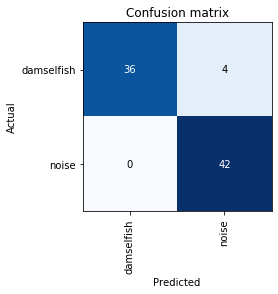

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
#learn.save("/workspaces/sonumator/stage1")
learn.unfreeze()

learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.089473,1.686682,0.780488,00:00
1,0.232218,7.038053,0.743902,00:00
2,0.215580,1.510298,0.780488,00:00
3,0.183351,0.808735,0.841463,00:00


In [17]:
learn.save('/workspaces/sonumator/stage1')

File: output/damselfish/0.wav
Total Length: 1.09 seconds
Number of Channels: 1
Label: noise/damselfish / 8.68 / 0.00
0.0s-1.0s of original clip
Channel 0.0 (192x19):
File: output/damselfish/68.wav
Total Length: 0.78 seconds
Number of Channels: 1
Label: noise/damselfish / 5.35 / 0.00
Channel 0.0 (192x19):
File: output/damselfish/31.wav
Total Length: 0.86 seconds
Number of Channels: 1
Label: noise/damselfish / 5.24 / 0.01
Channel 0.0 (192x19):
File: output/damselfish/182.wav
Total Length: 0.93 seconds
Number of Channels: 1
Label: noise/damselfish / 1.51 / 0.22
Channel 0.0 (192x19):
File: output/damselfish/55.wav
Total Length: 0.72 seconds
Number of Channels: 1
Label: damselfish/damselfish / 0.33 / 0.72
Channel 0.0 (192x19):
File: output/damselfish/8.wav
Total Length: 1.04 seconds
Number of Channels: 1
Label: damselfish/damselfish / 0.20 / 0.82
0.0s-1.0s of original clip
Channel 0.0 (192x19):
File: output/damselfish/80.wav
Total Length: 0.6 seconds
Number of Channels: 1
Label: damselfish/

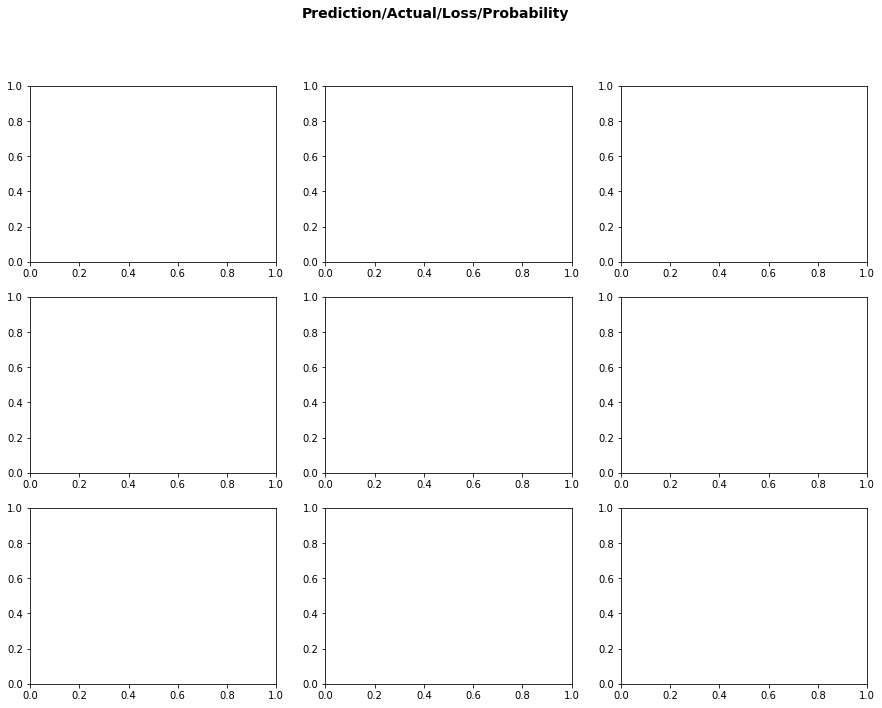

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage1")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

(Category damselfish, tensor(0), tensor([1.0000e+00, 3.0468e-21]))

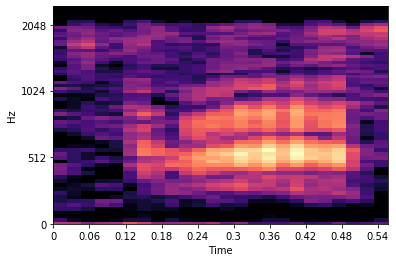

In [31]:
newsample_path = "damnew2.wav"
y, sr = librosa.load(
    newsample_path,
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

item = AudioItem(path=newsample_path)

audio_predict(learn, item)

In [21]:
learn.save('/workspaces/sonumator/stage2')

In [10]:
learn = audio_learner(db, pretrained=True)
learn.load("/workspaces/sonumator/stage2")
learn.model.eval()
learn.model.training = False

In [81]:
import torchaudio
import pandas as pd

def search_file_for_samples(filepath, model, offset=2):
    df = pd.DataFrame(columns=["start", "end"])

    si, ei = torchaudio.info(filepath)
    length = si.length / si.rate

    for i in range(0, int(length), offset):
        end = i + offset
        item = AudioItem(path=filepath, start=i, end=end)
        category, _, _ = audio_predict(learn, item)
        if str(category) == "damselfish":
            df = df.append([{"start": i, "end": end}])
    
    return df

df = search_file_for_samples("recordings/20150623-044023.wav", learn)
df.index = range(len(df.index))

In [82]:
df

,start,end
0,0,2
1,4,6
2,6,8
3,8,10
4,10,12
...,...,...
5169,14390,14392
5170,14392,14394
5171,14394,14396
5172,14396,14398


In [87]:
for i in range(200):
    row = df.iloc[i]
    start = row[0]
    end = row[1]

    item = AudioItem(path="recordings/20150623-044023.wav", start=start, end=end)
    category, _, _ = audio_predict(learn, item)
    print(f"start: {start}, end: {end}, {category}")

start: 0, end: 2, damselfish
start: 4, end: 6, damselfish
start: 6, end: 8, damselfish
start: 8, end: 10, damselfish
start: 10, end: 12, damselfish
start: 14, end: 16, damselfish
start: 16, end: 18, noise
start: 20, end: 22, damselfish
start: 22, end: 24, damselfish
start: 24, end: 26, noise
start: 26, end: 28, damselfish
start: 30, end: 32, damselfish
start: 32, end: 34, damselfish
start: 34, end: 36, noise
start: 36, end: 38, damselfish
start: 42, end: 44, damselfish
start: 44, end: 46, damselfish
start: 46, end: 48, damselfish
start: 48, end: 50, damselfish
start: 50, end: 52, damselfish
start: 56, end: 58, damselfish
start: 58, end: 60, damselfish
start: 60, end: 62, damselfish
start: 64, end: 66, damselfish
start: 68, end: 70, damselfish
start: 70, end: 72, damselfish
start: 72, end: 74, damselfish
start: 74, end: 76, damselfish
start: 76, end: 78, noise
start: 82, end: 84, noise
start: 84, end: 86, damselfish
start: 88, end: 90, damselfish
start: 90, end: 92, damselfish
start: 98

In [91]:
item = AudioItem(path="recordings/20150623-044023.wav", start=26, end=28)
al = AudioList([item], path=item.path, config=learn.data.x.config)
ai = AudioList.open(al, item.path)
for i in range(0, 100):
    category, x, y = learn.predict(ai)
    print(f"{category}, {x}, {y}")

noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.0534, 0.9466])
noise, 1, tensor([0.

In [31]:
import math
minute_counts = df.groupby('minute').count().iloc[:,0]

KeyError: 'minute'

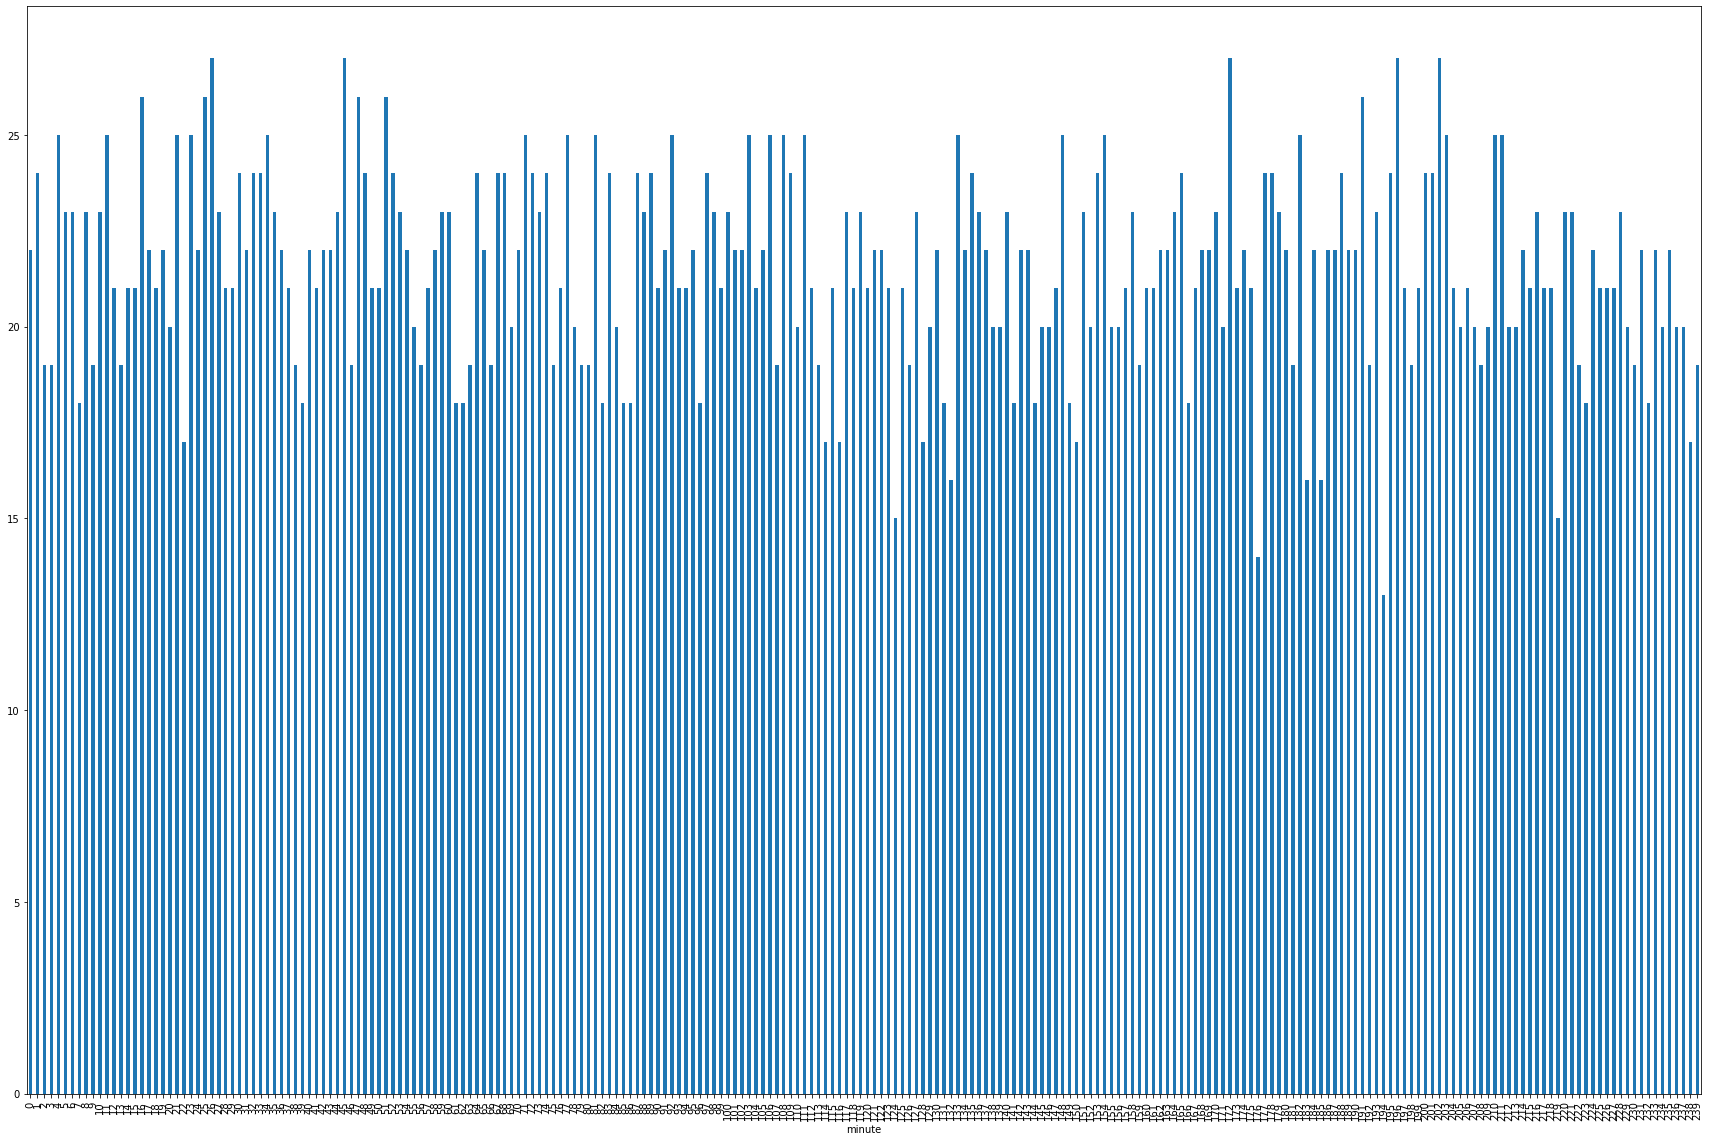

In [190]:
minute_counts.plot(kind="bar", figsize=(30,20))